In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [3]:
cancer=load_breast_cancer()
df=pd.DataFrame(cancer.data,columns=cancer.feature_names)
df['class']=cancer.target

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
data=torch.from_numpy(df.values).float()

x=data[:,:-1]
y=data[:,-1:]

print(x.shape,y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [8]:
# Train / Valid / Test ratio
ratios=[.6,.2,.2]

train_cnt=int(data.size(0)*ratios[0])
valid_cnt=int(data.size(0)*ratios[1])
test_cnt=data.size(0)-train_cnt-valid_cnt
cnts=[train_cnt,valid_cnt,test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt,valid_cnt,test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [9]:
indices=torch.randperm(data.size(0))

x=torch.index_select(x,dim=0,index=indices)
y=torch.index_select(y,dim=0,index=indices)

x=x.split(cnts,dim=0)
y=y.split(cnts,dim=0)

for x_i,y_i in zip(x,y):
    print(x_i.size(),y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [10]:
scaler=StandardScaler()
scaler.fit(x[0].numpy())

x=[torch.from_numpy(scaler.transform(x[0].numpy())).float(),
   torch.from_numpy(scaler.transform(x[1].numpy())).float(),
   torch.from_numpy(scaler.transform(x[2].numpy())).float()]

In [13]:
model=nn.Sequential(
    nn.Linear(x[0].size(-1),25),
    nn.LeakyReLU(),
    nn.Linear(25,20),
    nn.LeakyReLU(),
    nn.Linear(20,15),
    nn.LeakyReLU(),
    nn.Linear(15,10),
    nn.LeakyReLU(),
    nn.Linear(10,5),
    nn.LeakyReLU(),
    nn.Linear(5,y[0].size(-1)),
    nn.Sigmoid(),
)

optimizer=optim.Adam(model.parameters())

In [15]:
n_epochs=10000
batch_size=32
print_interval=10
early_stop=100
lowest_loss=np.inf
best_model=None
lowest_epoch=np.inf

In [17]:
train_history,valid_history=[],[]

for i in range(n_epochs):
    indices=torch.randperm(x[0].size(0))
    x_=torch.index_select(x[0],dim=0,index=indices)
    y_=torch.index_select(y[0],dim=0,index=indices)
    
    x_=x_.split(batch_size,dim=0)
    y_=y_.split(batch_size,dim=0)
    
    train_loss,valid_loss=0,0
    y_hat=[]
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=F.binary_cross_entropy(y_hat_i,y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss+=float(loss)
    
    train_loss=train_loss/len(x_)
    
    with torch.no_grad():
        x_=x[1].split(batch_size,dim=0)
        y_=y[1].split(batch_size,dim=0)
        
        valid_loss=0
        
        for x_i,y_i in zip(x_,y_):
            y_hat_i=model(x_i)
            loss=F.binary_cross_entropy(y_hat_i,y_i)
            
            valid_loss=float(loss)
            
            y_hat+=[y_hat_i]
    
    valid_loss=valid_loss/len(x_)
    
    train_history+=[train_loss]
    valid_history+=[valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4f valid_loss=%.4f lowest_loss=%.4f' %
(
            i+1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss<=lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i
        
        best_model=deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4f" %(lowest_epoch+1,lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=0.2315 valid_loss=0.0196 lowest_loss=0.0535
Epoch 20: train loss=0.0242 valid_loss=0.0001 lowest_loss=0.0001
Epoch 30: train loss=0.0243 valid_loss=0.0000 lowest_loss=0.0000
Epoch 40: train loss=0.0147 valid_loss=0.0001 lowest_loss=0.0000
Epoch 50: train loss=0.0168 valid_loss=0.0001 lowest_loss=0.0000
Epoch 60: train loss=0.0102 valid_loss=0.0000 lowest_loss=0.0000
Epoch 70: train loss=0.0087 valid_loss=0.0000 lowest_loss=0.0000
Epoch 80: train loss=0.0074 valid_loss=0.0000 lowest_loss=0.0000
Epoch 90: train loss=0.0058 valid_loss=0.0000 lowest_loss=0.0000
Epoch 100: train loss=0.0046 valid_loss=0.0000 lowest_loss=0.0000
Epoch 110: train loss=0.0040 valid_loss=0.0000 lowest_loss=0.0000
Epoch 120: train loss=0.0008 valid_loss=0.0000 lowest_loss=0.0000
Epoch 130: train loss=0.0004 valid_loss=0.0000 lowest_loss=0.0000
Epoch 140: train loss=0.0002 valid_loss=0.0000 lowest_loss=0.0000
Epoch 150: train loss=0.0001 valid_loss=0.0000 lowest_loss=0.0000
Epoch 160: train lo

Epoch 1270: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1280: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1290: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1300: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1310: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1320: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1330: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1340: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1350: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1360: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1370: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1380: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1390: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1400: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 1410: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.

Epoch 2500: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2510: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2520: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2530: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2540: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2550: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2560: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2570: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2580: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2590: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2600: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2610: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2620: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2630: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 2640: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.

Epoch 3730: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3740: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3750: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3760: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3770: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3780: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3790: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3800: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3810: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3820: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3830: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3840: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3850: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3860: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 3870: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.

Epoch 4960: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 4970: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 4980: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 4990: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5000: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5010: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5020: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5030: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5040: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5050: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5060: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5070: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5080: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5090: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.0000
Epoch 5100: train loss=0.0000 valid_loss=0.0000 lowest_loss=0.

<All keys matched successfully>

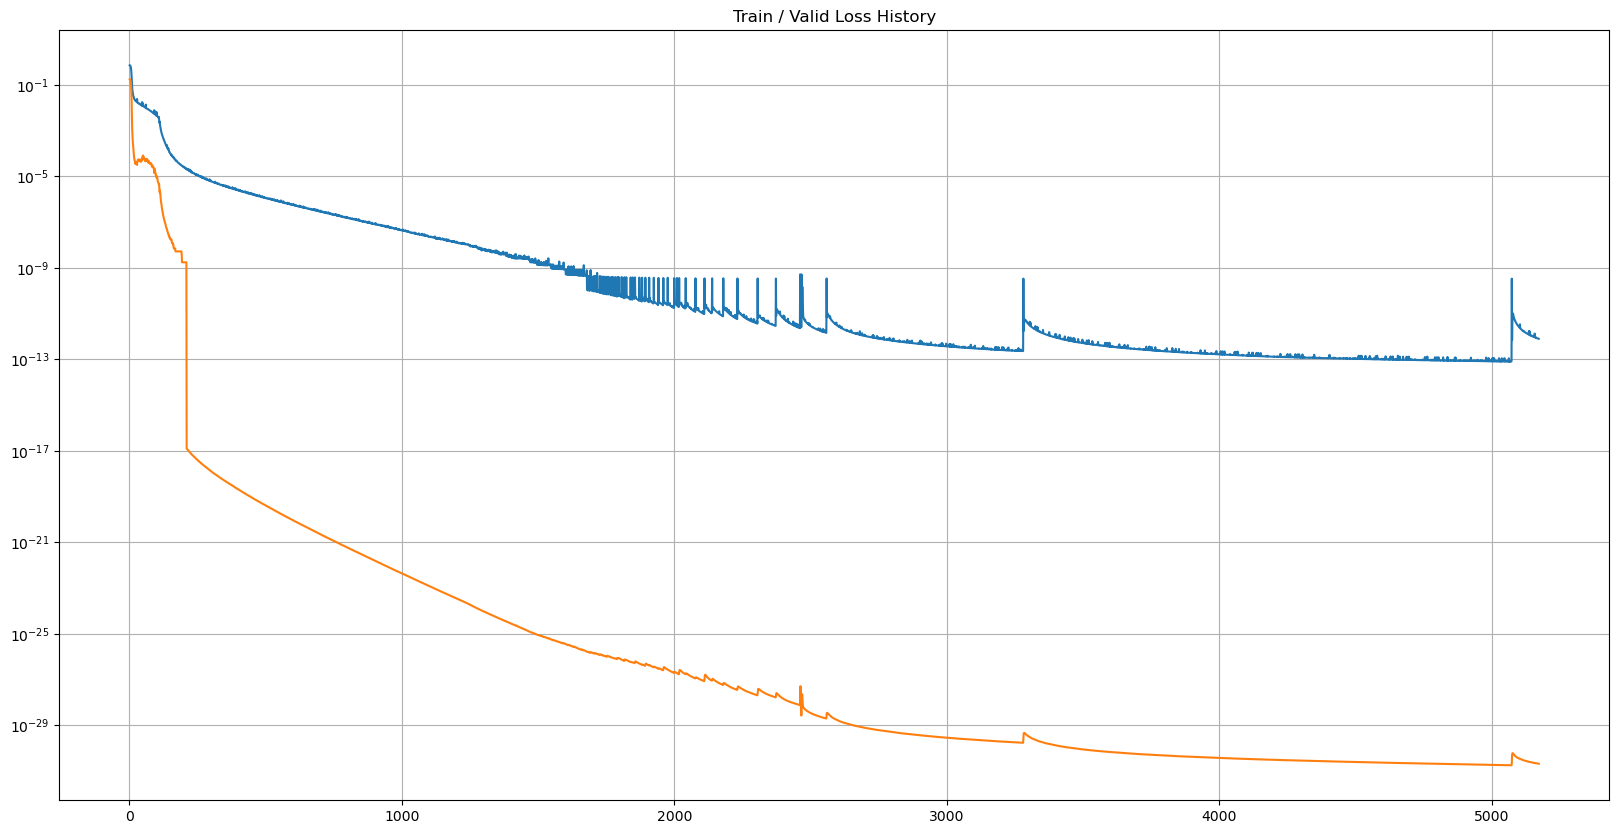

In [19]:
plot_from=2

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from,len(train_history)),train_history[plot_from:],
    range(plot_from,len(valid_history)),valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [23]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x[2].split(batch_size,dim=0)
    y_=y[2].split(batch_size,dim=0)
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=F.binary_cross_entropy(y_hat_i,y_i)
        test_loss+=loss
        
        y_hat+=[y_hat_i]
    
test_loss=test_loss/len(x_)
y_hat=torch.cat(y_hat,dim=0)

sorted_history=sorted(zip(train_history,valid_history),key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 8.4832e-14
Valid loss: 1.7781e-31
Test loss: 2.5824e+00


In [25]:
correct_cnt=(y[2]==(y_hat>.5)).sum()
total_cnt=float(y[2].size(0))
print('Test Accuracy: %.4f' %(correct_cnt/total_cnt))

Test Accuracy: 0.9391


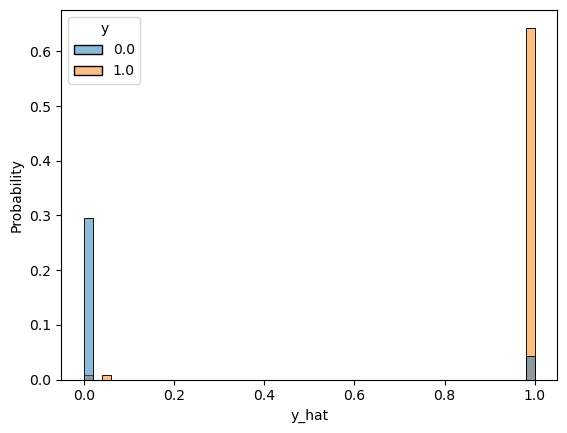

In [26]:
df=pd.DataFrame(torch.cat([y[2],y_hat],dim=1).detach().numpy(),columns=["y","y_hat"])
sns.histplot(df,x='y_hat',hue='y',bins=50,stat='probability')
plt.show()